# Mangle Spectra
----


In [1]:
# %matplotlib inline
%matplotlib notebook

from __future__ import print_function

try:
    reload  # Python 2.7
except NameError:
    try:
        from importlib import reload  # Python 3.4+
    except ImportError:
        from imp import reload  # Python 3.0 - 3.3

import sys
import os
import warnings
import copy

import numpy as np
import pandas as pd

from astropy.table import Table, Row, Column
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator
from scipy import interpolate

from lmfit import minimize, Parameters, fit_report

from collections import OrderedDict

import pycoco as pcc
import pyCoCo as pccsim

import lsst_tools as lsstt
from lcsim.simlib import SIMLIBReader
from lcsim.lcsim import LCSim

plotdir = os.path.join(os.environ['PYPLOTDIR'], 'SESNePaper/')

## Load in SN

<IPython.core.display.Javascript object>


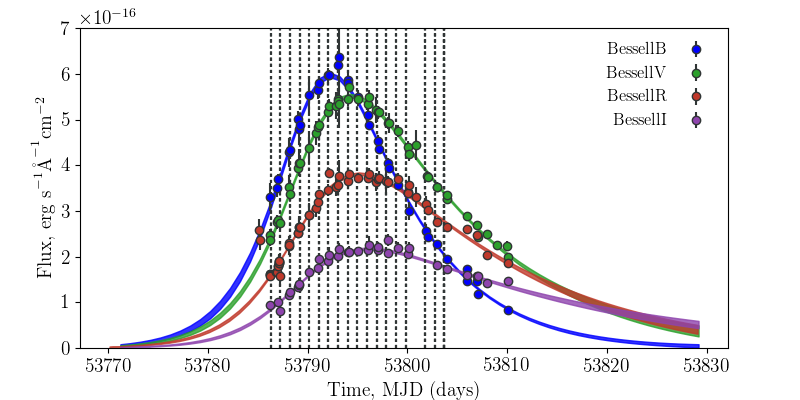

In [2]:
snname = "SN2006aj"
spec_filename = "SN2006aj_vlt_2006_03_10_z0.dat"
spec_mjd = 53803.68

verbose = False
plot = True
sn = pcc.SNClass(snname)
sn.load_phot(verbose=False)
sn.load_list("/Users/berto/Code/CoCo/lists/" + snname + ".list")
sn.load_spec()
sn.get_lcfit("/Users/berto/Code/CoCo/recon/" + snname + ".dat")
sn.check_overlaps()

spec_dir = "/Users/berto/Code/CoCo/data/spec/" + snname + "/"
S = pcc.SpectrumClass()
S.load(filename=spec_filename, directory=spec_dir)

sn.plot_lc(multiplot=False)

## Set up the Mangle
---
We need to know several things before we start - what filters we want to mangle, what the spectrophotometry is at the start, what is the flux that we want, and where the anchors are going to be.

First we should take a look at how far off the original spectrophotometry is compared to the best fit.

In [3]:
# filters = ["SDSS_g", "SDSS_r", "SDSS_i","SDSS_z"]
filters = ["BessellB", "BessellV", "BessellR", "BessellI"]

rows = OrderedDict()
filter_dict = OrderedDict()

for i, f in enumerate(filters):
    filter_dict[f] = pcc.kcorr.load_filter(os.path.join(pcc._default_filter_dir_path, f + ".dat"))
    filter_dict[f].calculate_edges()
    #     filter_dict[f].calculate_edges_zero()

    fit_flux = sn.lcfit.spline[f](spec_mjd)

    sn.phot.data_filters[f].resample_response(new_wavelength=S.wavelength)
    S_filter_flux = pcc.calc_spectrum_filter_flux(filter_object=sn.phot.data_filters[f], spectrum_object=S)
    S_filter_flux_no_area = pcc.calc_spectrum_filter_flux(filter_object=sn.phot.data_filters[f], spectrum_object=S,
                                                          correct_for_area=False)
    mS_filter_flux = np.NaN

    rows[f] = (fit_flux, S_filter_flux, S_filter_flux_no_area)
    if i == 0:
        data_table = Table(names=("filter", "fitflux", "spec_filterflux", "mangledspec_filterflux", "filter_object", "mask"),
            dtype=('S12', 'f4', 'f4', 'f4', object, bool))
    data_table.add_row((f, fit_flux, S_filter_flux, mS_filter_flux, filter_dict[f], True))

data_table

filter,fitflux,spec_filterflux,mangledspec_filterflux,filter_object,mask
bytes12,float32,float32,float32,object,bool
BessellB,2.03813e-16,5.17334e-17,nan,<pycoco.classes.FilterClass object at 0x1172db550>,True
BessellV,3.39305e-16,1.24878e-16,nan,<pycoco.classes.FilterClass object at 0x1172e1b38>,True
BessellR,2.77515e-16,1.08969e-16,nan,<pycoco.classes.FilterClass object at 0x1171ae630>,True
BessellI,1.78649e-16,6.12809e-17,nan,<pycoco.classes.FilterClass object at 0x1174292e8>,True


So the fitflux is brighter than the specflux by something like an order of two, apart from B-band (this will become important later). 

## Check Boundaries
---
The next step is to remove any filters that do not overlap with the spectra.

In [4]:
for i, f in enumerate(data_table["filter_object"]):
    ## Test extent
    bool_uncontained = np.logical_or(f._lower_edge < S.min_wavelength, f._upper_edge > S.max_wavelength)
    if verbose: print(bool_uncontained)
    if bool_uncontained:
        data_table = data_table[np.where(data_table["filter"] != pcc.utils.b(f.filter_name))]

knot_colours = [j._plot_colour for j in data_table["filter_object"] if hasattr(j, "_plot_colour")]
data_table.add_column(Column(knot_colours, name="knot_colours"))
data_table["lambda_eff"] = [i.lambda_effective.value for i in data_table["filter_object"]]
data_table

filter,fitflux,spec_filterflux,mangledspec_filterflux,filter_object,mask,knot_colours,lambda_eff
bytes12,float32,float32,float32,object,bool,str7,float64
BessellB,2.03813e-16,5.17334e-17,nan,<pycoco.classes.FilterClass object at 0x1172db550>,True,#0000ff,4354.41054934
BessellV,3.39305e-16,1.24878e-16,nan,<pycoco.classes.FilterClass object at 0x1172e1b38>,True,#2ca02c,5436.8698117
BessellR,2.77515e-16,1.08969e-16,nan,<pycoco.classes.FilterClass object at 0x1171ae630>,True,#c0392b,6416.11806798
BessellI,1.78649e-16,6.12809e-17,nan,<pycoco.classes.FilterClass object at 0x1174292e8>,True,#8e44ad,8011.65864198


Great, none got thrown out. Let's take a look at what we have. Below is a plot of the spectrum (blue), the spectrophotometry (blue-faced points), the filters and their corresponding fitflux, shon as stars. The vertical dotted lines show the region of the filter response that contains less than 3% of the total throughput, which we can consider the "edge" of the filter. 

<IPython.core.display.Javascript object>


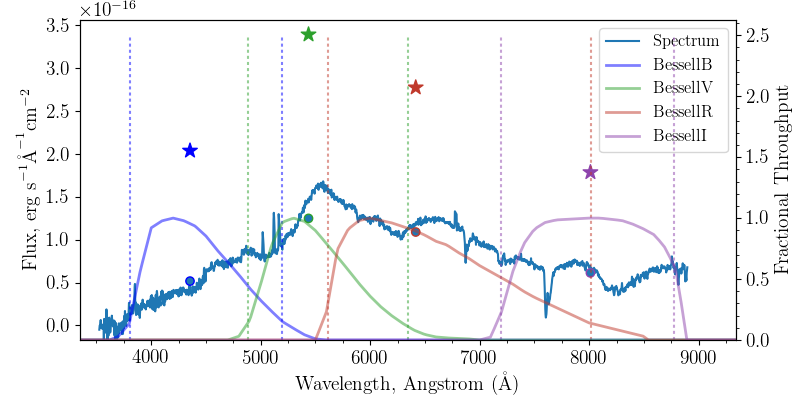

3.61679220407e-16


In [5]:
pcc.plot_mangledata(S, data_table, show_linear_extrap=False)

# Scaling the Spectra
---

From experience, fitting routines are more stable with values around unity. Values of ~10e-16 don't fit the bill, so I'm going to scale. The scaling I will do will adjust the B-Band spectrophotometry to match the flux from the fit. This will be done in two steps - one to get the spectrum in units of "B-Flux" (`scale-factor`) and then to match the spec and observed fluxes (`norm-factor`).

In [6]:
## Normalise data_table
# "wanted flux"
w = 0
scale_factor = 1. / data_table[w]["fitflux"]
print("Scale Factor", scale_factor)
norm_factor = data_table[w]["fitflux"] / data_table[w]["spec_filterflux"]
print("norm factor", norm_factor)
data_table["fitflux"] = data_table["fitflux"] * scale_factor
# "spec flux"
data_table["spec_filterflux"] = data_table["spec_filterflux"] * scale_factor
print("scaled ",)
nS = copy.deepcopy(S)
S.flux = S.flux * scale_factor
S.flux = S.flux * norm_factor
S.scale_factor = scale_factor
S.norm_factor = norm_factor
data_table

Scale Factor 4.9064503676e+15
norm factor 3.93969
scaled 


filter,fitflux,spec_filterflux,mangledspec_filterflux,filter_object,mask,knot_colours,lambda_eff
bytes12,float32,float32,float32,object,bool,str7,float64
BessellB,1.0,0.253827,nan,<pycoco.classes.FilterClass object at 0x1172db550>,True,#0000ff,4354.41054934
BessellV,1.66479,0.612709,nan,<pycoco.classes.FilterClass object at 0x1172e1b38>,True,#2ca02c,5436.8698117
BessellR,1.36161,0.534652,nan,<pycoco.classes.FilterClass object at 0x1171ae630>,True,#c0392b,6416.11806798
BessellI,0.876533,0.300672,nan,<pycoco.classes.FilterClass object at 0x1174292e8>,True,#8e44ad,8011.65864198


In [7]:
print("normalised")
data_table["spec_filterflux"] = data_table["spec_filterflux"] * norm_factor
data_table

normalised


filter,fitflux,spec_filterflux,mangledspec_filterflux,filter_object,mask,knot_colours,lambda_eff
bytes12,float32,float32,float32,object,bool,str7,float64
BessellB,1.0,1.0,nan,<pycoco.classes.FilterClass object at 0x1172db550>,True,#0000ff,4354.41054934
BessellV,1.66479,2.41388,nan,<pycoco.classes.FilterClass object at 0x1172e1b38>,True,#2ca02c,5436.8698117
BessellR,1.36161,2.10636,nan,<pycoco.classes.FilterClass object at 0x1171ae630>,True,#c0392b,6416.11806798
BessellI,0.876533,1.18455,nan,<pycoco.classes.FilterClass object at 0x1174292e8>,True,#8e44ad,8011.65864198


Ok, great, let's take a look at what that has done to the plot:

<IPython.core.display.Javascript object>


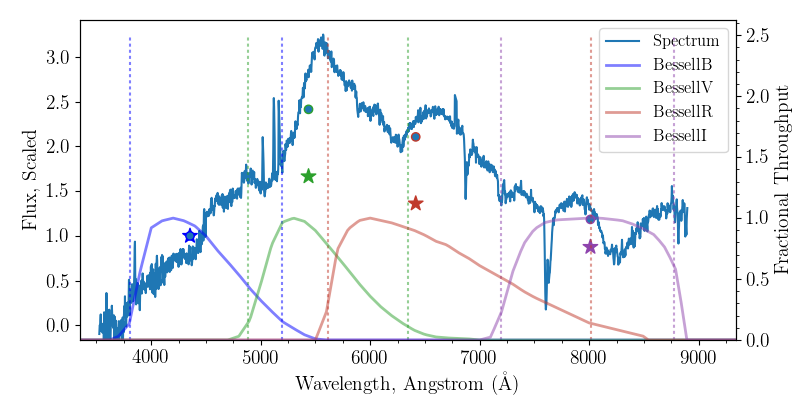

3.44068561682


In [8]:
pcc.plot_mangledata(S, data_table, show_linear_extrap=False, units=False)

The specphot points now lie *above* those of the fit for the filters other than Bessell B. 

## Anchor Points
___
The mangling function we will use in this example is a cubic spline ([see here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.CubicSpline.html)). To make sure we have reasonable behaviour all the way out to the edges of the wavelength range covered by the filters, we will anchor the  spline to two knots, one blueward of the first filter and one redward of the last filter, by 100 Angstroms. In some implementations, these anchors can move up and down during the minimisation. To set the _initial_ position, we can just linearly extrapolate from the two nearest filters.

In [9]:
## Lower
anchor_min_wavelength = np.nanmin([i._lower_edge for i in data_table["filter_object"]]) - 100
## x1-x2
dx = data_table["lambda_eff"][0] - data_table["lambda_eff"][1]
if verbose: print(dx)
## y1 - y2
dy = data_table["fitflux"][0] - data_table["fitflux"][1]
if verbose: print(dy)
##
m_lower = dy / dx
c_lower = data_table["fitflux"][0] - m_lower * data_table["lambda_eff"][0]
if verbose: print(m_lower, c_lower)

## Upper
anchor_max_wavelength = np.nanmax([i._upper_edge for i in data_table["filter_object"]]) + 100
## x1-x2
dx = data_table["lambda_eff"][-2] - data_table["lambda_eff"][-1]
if verbose: print(dx)
## y1 - y2
dy = data_table["fitflux"][-2] - data_table["fitflux"][-1]
if verbose: print(dy)
##
m_upper = dy / dx
c_upper = data_table["fitflux"][-2] - m_upper * data_table["lambda_eff"][-2]
if verbose: print(m_upper, c_upper)

spl_wav = S.data['wavelength'][np.logical_and(S.data['wavelength'] >= anchor_min_wavelength, S.data['wavelength'] <= anchor_max_wavelength)]

data_table.add_row(("lower_anchor", anchor_min_wavelength * m_lower + c_lower, anchor_min_wavelength * m_lower + c_lower,
                   anchor_min_wavelength * m_lower + c_lower, np.nan, False,
                   pcc.hex["batman"], anchor_min_wavelength))
data_table.add_row(("upper_anchor", anchor_max_wavelength * m_upper + c_upper, anchor_max_wavelength * m_upper + c_upper,
                   anchor_max_wavelength * m_upper + c_upper, np.nan, False,
                   pcc.hex["batman"], anchor_max_wavelength))

orig_data_table = data_table

data_table.add_index("lambda_eff")
data_table.sort()
data_table

filter,fitflux,spec_filterflux,mangledspec_filterflux,filter_object,mask,knot_colours,lambda_eff
bytes12,float32,float32,float32,object,bool,str7,float64
lower_anchor,0.600051,0.600051,0.600051,nan,False,#303535,3703.17996744
BessellB,1.0,1.0,nan,<pycoco.classes.FilterClass object at 0x1172db550>,True,#0000ff,4354.41054934
BessellV,1.66479,2.41388,nan,<pycoco.classes.FilterClass object at 0x1172e1b38>,True,#2ca02c,5436.8698117
BessellR,1.36161,2.10636,nan,<pycoco.classes.FilterClass object at 0x1171ae630>,True,#c0392b,6416.11806798
BessellI,0.876533,1.18455,nan,<pycoco.classes.FilterClass object at 0x1174292e8>,True,#8e44ad,8011.65864198
upper_anchor,0.615137,0.615137,0.615137,nan,False,#303535,8871.44831678


<IPython.core.display.Javascript object>


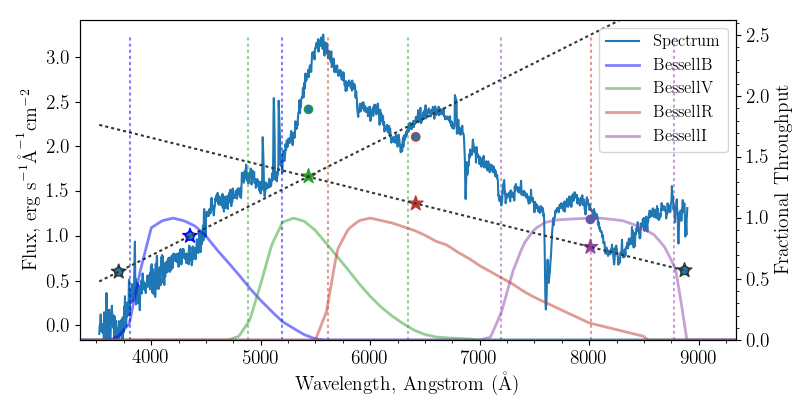

4.00789181586


In [10]:
pcc.plot_mangledata(S, data_table, show_linear_extrap=True, c_upper=c_upper, c_lower=c_lower, m_upper=m_upper, m_lower=m_lower)

Looks good. We will now get rid of the NaN's in the mangledspec_filterflux column, by giving an initial flux. If we have done everything right, this integration will give us the same as the spec_filterflux column. Which, as we can see below, it does.

In [11]:
for i, f in enumerate(data_table["filter_object"]):
    if isinstance(f, pcc.FilterClass):
        mangledspec_filterflux = pcc.calc_spectrum_filter_flux(filter_object=f, spectrum_object=S)
#         print(data_table["spec_filterflux"][i], mangledspec_filterflux)
        data_table["mangledspec_filterflux"][i] = mangledspec_filterflux
    else:
        pass
data_table

filter,fitflux,spec_filterflux,mangledspec_filterflux,filter_object,mask,knot_colours,lambda_eff
bytes12,float32,float32,float32,object,bool,str7,float64
lower_anchor,0.600051,0.600051,0.600051,nan,False,#303535,3703.17996744
BessellB,1.0,1.0,1.0,<pycoco.classes.FilterClass object at 0x1172db550>,True,#0000ff,4354.41054934
BessellV,1.66479,2.41388,2.41388,<pycoco.classes.FilterClass object at 0x1172e1b38>,True,#2ca02c,5436.8698117
BessellR,1.36161,2.10636,2.10636,<pycoco.classes.FilterClass object at 0x1171ae630>,True,#c0392b,6416.11806798
BessellI,0.876533,1.18455,1.18455,<pycoco.classes.FilterClass object at 0x1174292e8>,True,#8e44ad,8011.65864198
upper_anchor,0.615137,0.615137,0.615137,nan,False,#303535,8871.44831678


# Minimisation
___
We are now nearly ready to start the minimisation. For the minimisation we will be using `lmfit` ([see here](https://lmfit.github.io/lmfit-py/index.html)), and the default algorithm, levenberg-marquardt.

The parameter that we want to change is the relative scale factor of a knot, at the effective wavelength of each filter, which will be fit by a spline. The input spectrum will be multiplied by that spline, and the spectrophotometry re-calculated. The value we want to minimise is the residual between the spectrophotometry and the fit flux.

Let's go about taking a look at the function, and setting the initial parameter guesses.

In [12]:
original_spectrum_flux = data_table[data_table["mask"]]["spec_filterflux"].data
scaled_spectrum_flux = data_table[data_table["mask"]]["mangledspec_filterflux"].data
wanted_flux = data_table[data_table["mask"]]["fitflux"].data
wanted_filters = data_table[data_table["mask"]]["filter_object"].data

if len(scaled_spectrum_flux) == len(wanted_flux):
    params = Parameters()
    for i, flux_tuple in enumerate(zip(scaled_spectrum_flux, wanted_flux)):
        params.add(wanted_filters[i].filter_name, value=flux_tuple[1] / flux_tuple[0])
params

Parameters([('BessellB', <Parameter 'BessellB', 1.0, bounds=[-inf:inf]>),
            ('BessellV',
             <Parameter 'BessellV', 0.68967229, bounds=[-inf:inf]>),
            ('BessellR',
             <Parameter 'BessellR', 0.64643002, bounds=[-inf:inf]>),
            ('BessellI',
             <Parameter 'BessellI', 0.73996937, bounds=[-inf:inf]>)])

In [13]:
paramlist = np.array([params[key].value for key in params.keys()])

data_table["weights"] = Column(np.append(1, np.append(paramlist, 1)), name="weights")

mc_l, mc_u = pcc.calc_linear_terms(data_table[data_table["mask"]], key="weights", verbose=True)
weight_l = mc_l[0] * data_table["lambda_eff"][0] + mc_l[1]
weight_u = mc_u[0] * data_table["lambda_eff"][-1] + mc_u[1]

weights = np.append(np.append(weight_l, paramlist), weight_u)
data_table["weights"] = weights
data_table

-1082.45926236
0.310327708721
-0.000286687656074 2.24835575397
-1595.540574
-0.0935393571854
5.86254957786e-05 0.270281912855


filter,fitflux,spec_filterflux,mangledspec_filterflux,filter_object,mask,knot_colours,lambda_eff,weights
bytes12,float32,float32,float32,object,bool,str7,float64,float64
lower_anchor,0.600051,0.600051,0.600051,nan,False,#303535,3703.17996744,1.18669976909
BessellB,1.0,1.0,1.0,<pycoco.classes.FilterClass object at 0x1172db550>,True,#0000ff,4354.41054934,1.0
BessellV,1.66479,2.41388,2.41388,<pycoco.classes.FilterClass object at 0x1172e1b38>,True,#2ca02c,5436.8698117,0.689672291279
BessellR,1.36161,2.10636,2.10636,<pycoco.classes.FilterClass object at 0x1171ae630>,True,#c0392b,6416.11806798,0.646430015564
BessellI,0.876533,1.18455,1.18455,<pycoco.classes.FilterClass object at 0x1174292e8>,True,#8e44ad,8011.65864198,0.739969372749
upper_anchor,0.615137,0.615137,0.615137,nan,False,#303535,8871.44831678,0.7903749687


## The Minimisation Function
The function itself looks like this:


In [14]:
def manglemin(params, SpectrumObject, data_table, verbose=False, clamped=False, *args, **kwargs):
    """
    """
    MangledSpectrumObject = copy.deepcopy(SpectrumObject)
    paramlist = np.array([params[key].value for key in params.keys()])

    # weights = append(append(1.0, paramlist), 1.0)
    mc_l, mc_u = pcc.calc_linear_terms(data_table[data_table["mask"]], key="weights")
    data_table["weights"][0] = mc_l[0] * data_table["lambda_eff"][0] + mc_l[1]
    data_table["weights"][-1] = mc_u[0] * data_table["lambda_eff"][-1] + mc_u[1]
    weights = data_table["weights"].data
    #     print(weights)
    data_table["weights"][data_table["mask"]] = paramlist

    data_table["mangledspec_filterflux"][0] = data_table["spec_filterflux"][0] * data_table["weights"][0]
    data_table["mangledspec_filterflux"][-1] = data_table["spec_filterflux"][-1] * data_table["weights"][-1]

    if clamped:
        SplObj = interpolate.CubicSpline(data_table["lambda_eff"], weights, bc_type = "clamped")
    else:
        SplObj = interpolate.CubicSpline(data_table["lambda_eff"], weights)

    MangledSpectrumObject.flux = MangledSpectrumObject.flux * SplObj(MangledSpectrumObject.wavelength)

    specflux = np.array([pcc.calc_spectrum_filter_flux(filter_object=FilterObject, spectrum_object=MangledSpectrumObject) for
         FilterObject in data_table[data_table["mask"]]["filter_object"]])
    if verbose:
        print("params:", paramlist)
        print("weights:", weights)
        print("flux:", specflux)
        print("fitflux:", data_table[data_table["mask"]]["fitflux"].data)

    return data_table[data_table["mask"]]["fitflux"] - specflux

# Go!

In [15]:
out = minimize(manglemin, params, args=(S, data_table), kws=({"verbose":False}))
# out = minimize(manglemin, params, args=(S, data_table), epsfcn=1e-5)
print(fit_report(out))

[[Fit Statistics]]
    # function evals   = 18
    # data points      = 4
    # variables        = 4
    chi-square         = 0.000
    reduced chi-square = inf
    Akaike info crit   = -61.963
    Bayesian info crit = -64.418
[[Variables]]
    BessellB:   1.09606985 +/- inf      (inf%) (init= 1)
    BessellV:   0.68814243 +/- inf      (inf%) (init= 0.6896723)
    BessellR:   0.63212342 +/- inf      (inf%) (init= 0.64643)
    BessellI:   0.74371778 +/- inf      (inf%) (init= 0.7399694)


Good - something happened! The initial guesses were good, so the weighting hasn't moved too far. Let's take a look at the result, and calculate the final mangle.

In [16]:
final_spl = interpolate.CubicSpline(data_table["lambda_eff"], data_table["weights"], bc_type = "clamped")
mS = copy.deepcopy(S)
mS.flux = mS.flux*final_spl(mS.wavelength)

verbose = False
for i, f in enumerate(data_table["filter_object"]):
    if isinstance(f, pcc.FilterClass):
        mangledspec_filterflux = pcc.calc_spectrum_filter_flux(filter_object=f, spectrum_object=mS)
        if verbose: print(data_table["spec_filterflux"][i], data_table["fitflux"][i], mangledspec_filterflux)
        data_table["mangledspec_filterflux"][i] = mangledspec_filterflux
data_table

filter,fitflux,spec_filterflux,mangledspec_filterflux,filter_object,mask,knot_colours,lambda_eff,weights
bytes12,float32,float32,float32,object,bool,str7,float64,float64
lower_anchor,0.600051,0.600051,0.804961,nan,False,#303535,3703.17996744,1.34148768964
BessellB,1.0,1.0,0.996993,<pycoco.classes.FilterClass object at 0x1172db550>,True,#0000ff,4354.41054934,1.09606985297
BessellV,1.66479,2.41388,1.66065,<pycoco.classes.FilterClass object at 0x1172e1b38>,True,#2ca02c,5436.8698117,0.688142434067
BessellR,1.36161,2.10636,1.3631,<pycoco.classes.FilterClass object at 0x1171ae630>,True,#c0392b,6416.11806798,0.632123429695
BessellI,0.876533,1.18455,0.878374,<pycoco.classes.FilterClass object at 0x1174292e8>,True,#8e44ad,8011.65864198,0.74371778116
upper_anchor,0.615137,0.615137,0.494479,nan,False,#303535,8871.44831678,0.803852680069


Fantastic, the mangled spectrum spectrophotometry matches that of the fit. Let's look!

<IPython.core.display.Javascript object>


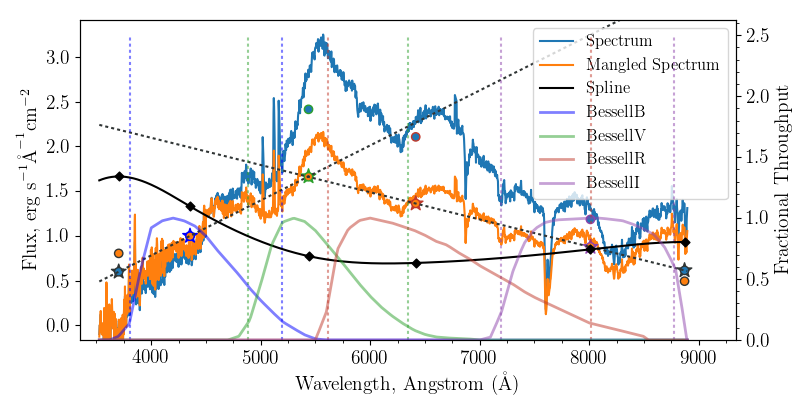

4.0174480111


In [17]:
pcc.plot_mangledata(S, data_table, mS=mS, spl = final_spl, show_linear_extrap=True,
                c_upper=c_upper, c_lower=c_lower, m_upper=m_upper, m_lower=m_lower,)

# Getting Back to 'Sensible' Units
___

Luckily we kept the scale factors down the back of the digital sofa, as class variables accessable as methods in our `SpectrumClass` instance, `S`.

In [18]:
print("Scale Factor is:", S.scale_factor)
print("Norm Factor is:", S.norm_factor)

Scale Factor is: 4.9064503676e+15
Norm Factor is: 3.93969


In [19]:
oS = pcc.SpectrumClass()
oS.load(filename=spec_filename, directory=spec_dir)

<IPython.core.display.Javascript object>


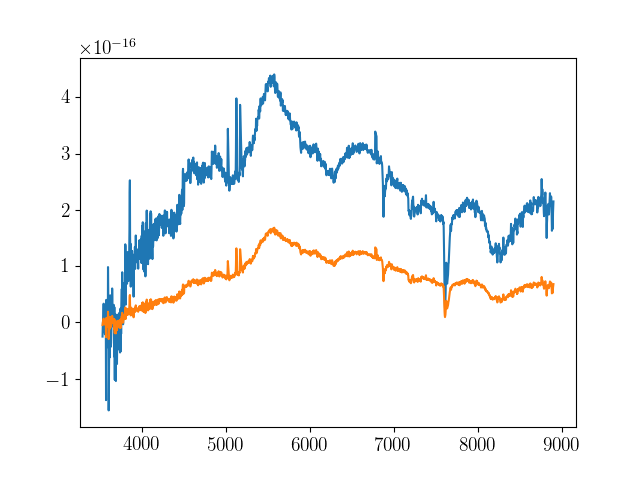

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(mS.wavelength, mS.flux/mS.scale_factor)
ax.plot(oS.wavelength, oS.flux)

In [21]:
mS.flux = mS.flux/mS.scale_factor

In [22]:
snname
out_path = snname+"_"+str(spec_mjd).ljust(12, "0") + ".spec"
out_path

'SN2006aj_53803.680000.spec'

In [23]:
import warnings
from astropy.table import Table

def save_mangle(mS, filename, orig_filename, path = False,
             squash = False, verbose = True, *args, **kwargs):
    """
    """
    if hasattr(mS, "data"):
        if verbose: print("has data")
        if not path:
            if verbose: print("No directory specified, assuming " + mS._default_data_dir_path)
            path = mS._default_data_dir_path
        else:
            pcc.StringWarning(path)

        outpath = os.path.join(path, filename)

        pcc.check_dir_path(path)
        
        save_table = Table()

        save_table['wavelength'] = mS.wavelength
        save_table['flux'] = mS.flux

        save_table['wavelength'].format = "5.5f"
        save_table['flux'].format = "5.5e"
        
        save_table.meta["comments"] = [orig_filename,]
        
        if os.path.isfile(outpath):
            if squash:
                print("Overwriting " + outpath)
                save_table.write(outpath, format = "ascii.no_header", overwrite=True)
            else:
                warnings.warn("Found existing file matching " + os.path.join(path,
                                                                             filename) + ". Run with squash = True to overwrite")
        else:
                print("Writing " + outpath)
                save_table.write(outpath, format = "ascii.no_header")

    else:
        warnings.warn("Doesn't seem to be any data here (empty self.data)")
    pass

In [24]:
orig_specname = os.path.join(spec_dir, spec_filename)
save = False
if save:
    save_mangle(mS, filename=out_path, orig_filename = orig_specname, path=os.path.curdir, squash=True)

In [25]:
manglespec = []
fitflux = []
for i, f in enumerate(data_table["filter_object"]):
    if isinstance(f, pcc.FilterClass):
        fit_flux = np.float64(sn.lcfit.spline[f.filter_name](spec_mjd))
        fitflux.append(fit_flux)
        mangledspec_filterflux = pcc.calc_spectrum_filter_flux(filter_object=f, spectrum_object=mS)
        manglespec.append(mangledspec_filterflux)
        original_spec_filterflux = pcc.calc_spectrum_filter_flux(filter_object=f, spectrum_object=oS)
        print(data_table["spec_filterflux"][i], data_table["fitflux"][i], fit_flux, mangledspec_filterflux, original_spec_filterflux, 100.0*data_table["fitflux"][i]/mangledspec_filterflux/mS.scale_factor)

1.0 1.0 2.03813336585e-16 2.03200505548e-16 5.17333915353e-17 100.3015873
2.41388 1.66479 3.39305481992e-16 3.38462900608e-16 1.24878153686e-16 100.248943347
2.10636 1.36161 2.7751516491e-16 2.7781820603e-16 1.08969150139e-16 99.8909271486
1.18455 0.876533 1.78649082761e-16 1.79024297428e-16 6.1280936766e-17 99.7904107329


# Running as a Script
____
The above has been turned into a set of functions, which live in `*pycoco.kcorr*` and `*pycoco.functions*`. They are:
* `plot_mangledata`,  
* `save_mangle`
* `applymangle`
* `calculate_fluxes`
* `manglemin`
* `plot_mangledata`
* `manglespec3`
* `mangle`
___

## Run SN2006aj again

In [44]:
snname = "SN2006aj"
spec_filename = "SN2006aj_vlt_2006_03_10_z0.dat"
spec_mjd = 53803.68

verbose = False
plot = True
sn = pcc.SNClass(snname)
sn.load_phot(verbose=False)
sn.load_list("/Users/berto/Code/CoCo/lists/" + snname + ".list")
sn.load_spec()
sn.get_lcfit("/Users/berto/Code/CoCo/recon/" + snname + ".dat")
sn.check_overlaps()

spec_dir = "/Users/berto/Code/CoCo/data/spec/" + snname + "/"
S = pcc.SpectrumClass()
S.load(filename=spec_filename, directory=spec_dir)

In [47]:
w = 18
specpath = sn.list[w]["spec_path"]

full_path = os.path.join(pcc._default_coco_dir_path, specpath)
full_path

'/Users/berto/Code/CoCo/data/spec/SN2006aj/SN2006aj_vlt_2006_03_10_z0.dat'

In [49]:
mS = sn.spec[specpath.split("/")[-1]]

wantedfilters = sn.phot.filter_names.data

S = copy.deepcopy(mS)
fit_dict = pcc.mangle(sn, mS, mS.mjd_obs, wantedfilters)

False
False
False
False
Scale Factor 4.90645100481e+15
norm factor 3.93969
scaled 
-3657.24809263
0.123467
-3.37595440653e-05 1.14700291482
979.248256276
-0.303171
-0.00030959581076 3.3480177409
-1082.45926236
0.310327708721
-0.000286687656074 2.24835575397
-1595.540574
-0.09353941679
5.86255331356e-05 0.270281673168
[[Fit Statistics]]
    # function evals   = 18
    # data points      = 4
    # variables        = 4
    chi-square         = 0.000
    reduced chi-square = inf
    Akaike info crit   = -61.963
    Bayesian info crit = -64.417
[[Variables]]
    BessellB:   1.09606981 +/- inf      (inf%) (init= 1)
    BessellV:   0.68814249 +/- inf      (inf%) (init= 0.6896723)
    BessellR:   0.63212338 +/- inf      (inf%) (init= 0.64643)
    BessellI:   0.74371790 +/- inf      (inf%) (init= 0.7399694)


In [56]:
out_path = snname+"_"+str(spec_mjd).ljust(12, "0") + ".spec"

In [57]:
nb_mS = pcc.SpectrumClass()
nb_mS.load(filename=out_path, directory=os.path.curdir)

<IPython.core.display.Javascript object>


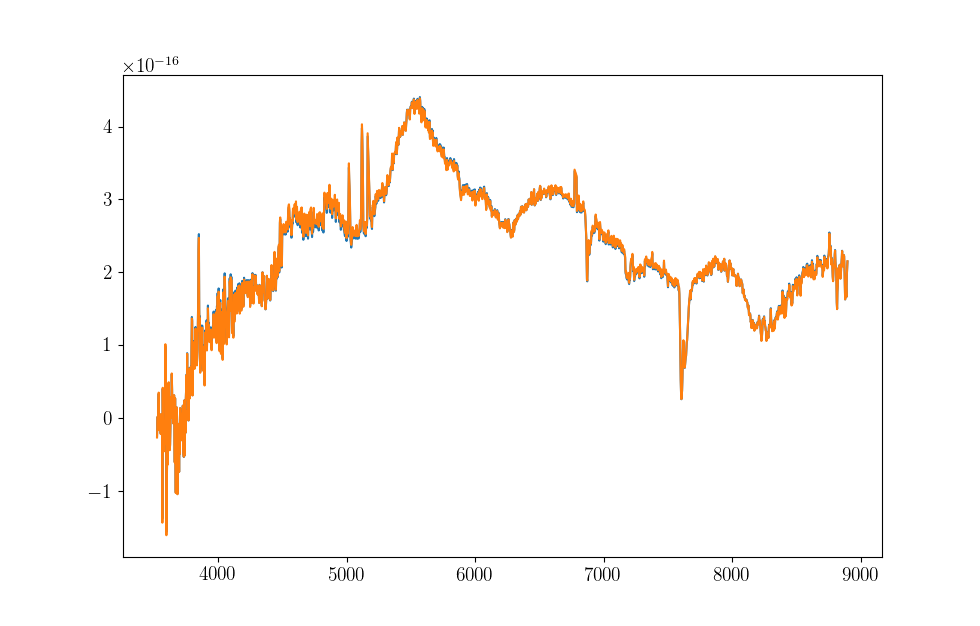

In [58]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(fit_dict["SpectrumObject"].wavelength, fit_dict["SpectrumObject"].flux)
ax.plot(nb_mS.wavelength, nb_mS.flux)

<IPython.core.display.Javascript object>


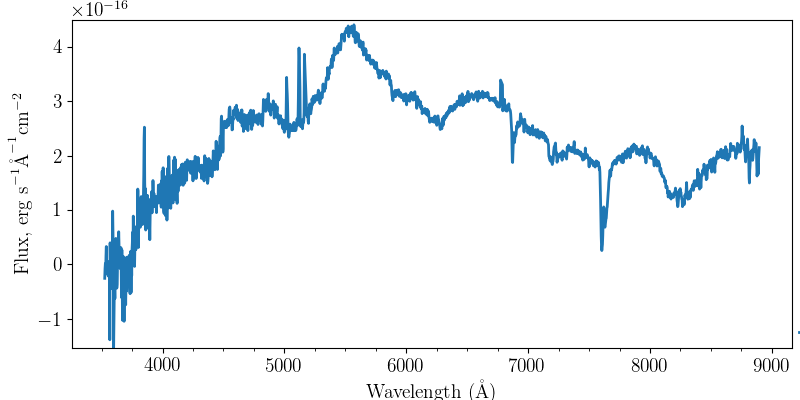

In [53]:
fit_dict["SpectrumObject"].plot()


## Running an example SNe
___


<IPython.core.display.Javascript object>


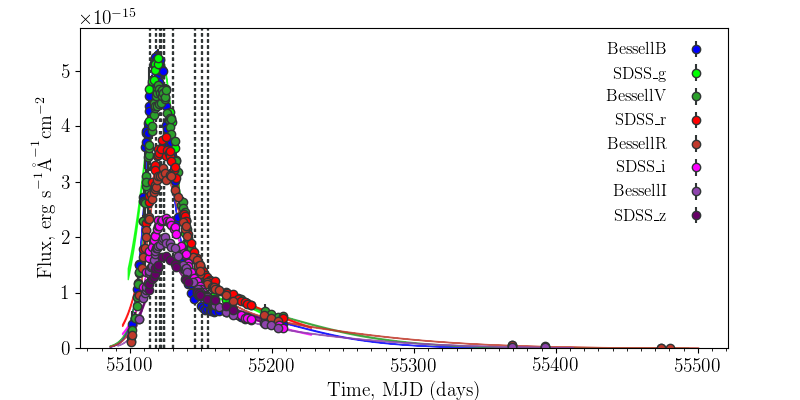

In [26]:
snname = "SN2009jf"

verbose = False
plot = True
sn = pcc.SNClass(snname)
sn.load_phot(verbose=False)
sn.load_list("/Users/berto/Code/CoCo/lists/" + snname + ".list")
sn.load_spec()
sn.get_lcfit("/Users/berto/Code/CoCo/recon/" + snname + ".dat")
sn.check_overlaps()

spec_dir = "/Users/berto/Code/CoCo/data/spec/" + snname + "/"

sn.plot_lc(multiplot=False)

In [27]:
w = 0
specpath = sn.list[w]["spec_path"]

full_path = os.path.join(pcc._default_coco_dir_path, specpath)

In [28]:
full_path

'/Users/berto/Code/CoCo/data/spec/SN2009jf/2009jf_-7.64.txt'

In [29]:
# S = pcc.SpectrumClass()
# S.load(filename=full_path, abspath=True)

mS = sn.spec["2009jf_-7.64.txt"]

<IPython.core.display.Javascript object>


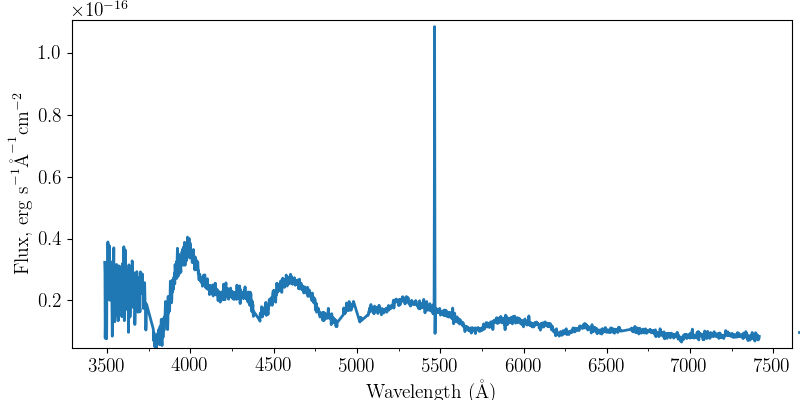

In [30]:
mS.plot()

In [31]:
mS.mjd_obs

55114.059999999998

In [32]:
wantedfilters = sn.phot.filter_names.data

In [33]:
S = copy.deepcopy(mS)
fit_dict = pcc.mangle(sn, mS, mS.mjd_obs, wantedfilters)

False
True
True
False
False
True
False
True
Scale Factor 2.21301253618e+14
norm factor 203.859
scaled 
-1082.45926236
0.188782
-0.000174400833778 1.75941283042
-1438.05471663
0.353467
-0.000245795477148 2.12858933298
-421.204619925
-0.0625423192978
0.00014848440957 0.353437801346
-776.800074192
-0.02055311203
2.64586895816e-05 1.00325598499
[[Fit Statistics]]
    # function evals   = 15
    # data points      = 4
    # variables        = 4
    chi-square         = 0.000
    reduced chi-square = inf
    Akaike info crit   = -32.729
    Bayesian info crit = -35.184
[[Variables]]
    BessellB:   1.00077033 +/- inf      (inf%) (init= 0.9999999)
    SDSS_g:     1.07024199 +/- inf      (inf%) (init= 1.062542)
    BessellV:   1.15174827 +/- inf      (inf%) (init= 1.147108)
    SDSS_r:     1.16732968 +/- inf      (inf%) (init= 1.167662)


/Users/berto/Code/verbose-enigma/pycoco/kcorr.py:216: RuntimeWarning: invalid value encountered in double_scalars
  return  integrated_flux/filter_area


In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(mS.wavelength, mS.flux/mS.scale_factor)
ax.plot(oS.wavelength, oS.flux)

In [35]:
print(fit_dict["SpectrumObject"].flux/S.flux)

         flux         
erg / (Angstrom cm2 s)
----------------------
         187.060048971
         186.989131042
         186.918780729
         186.848996863
         186.779778274
         186.711592113
         186.643496718
         186.575963098
         186.508990086
          186.44257651
                   ...
         234.145596055
         234.105099279
         234.064447714
         234.023641116
         233.982679239
         233.941843992
         233.900571887
         233.859143766
         233.817559385
         233.775818497
Length = 2674 rows


<IPython.core.display.Javascript object>


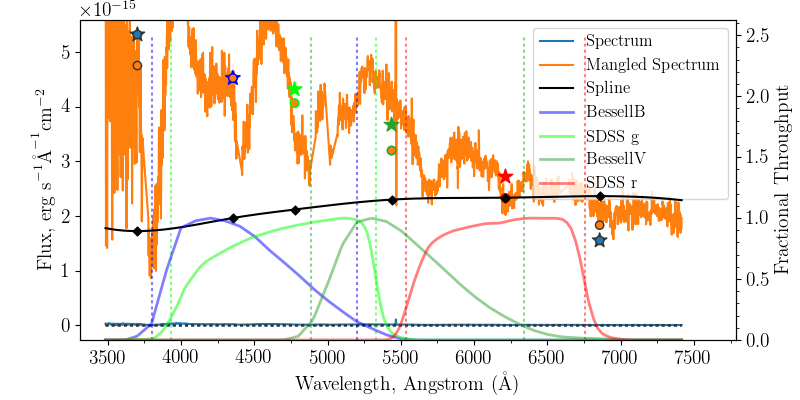

2.6815754718e-14


In [36]:
# S, data_table, mS=mS, spl = final_spl, show_linear_extrap=True,
#                 c_upper=c_upper, c_lower=c_lower, m_upper=m_upper, m_lower=m_lower,)

pcc.plot_mangledata(S, fit_dict["data_table"], mS=fit_dict["SpectrumObject"], spl=fit_dict["final_spl"])

In [37]:
fit_dict["data_table"]

filter,fitflux,spec_filterflux,mangledspec_filterflux,filter_object,mask,knot_colours,lambda_eff,weights
bytes12,float32,float32,float32,object,bool,str7,float64,float64
lower_anchor,5.31476e-15,5.31476e-15,4.74799e-15,nan,False,#303535,3703.17996744,0.893359198215
BessellB,4.51873e-15,4.51873e-15,4.51873e-15,<pycoco.classes.FilterClass object at 0x117fc2748>,True,#0000ff,4354.41054934,1.00077033657
SDSS_g,4.31432e-15,4.06038e-15,4.06038e-15,<pycoco.classes.FilterClass object at 0x117f6a668>,True,#00ff00,4775.61516927,1.07024199448
BessellV,3.66567e-15,3.19558e-15,3.19558e-15,<pycoco.classes.FilterClass object at 0x117e50e80>,True,#2ca02c,5436.8698117,1.15174827852
SDSS_r,2.7171e-15,2.32696e-15,2.32696e-15,<pycoco.classes.FilterClass object at 0x117e72208>,True,#ff0000,6213.6698859,1.16732968568
upper_anchor,1.55264e-15,1.55264e-15,1.83245e-15,nan,False,#303535,6856.04887786,1.18021484573


<IPython.core.display.Javascript object>


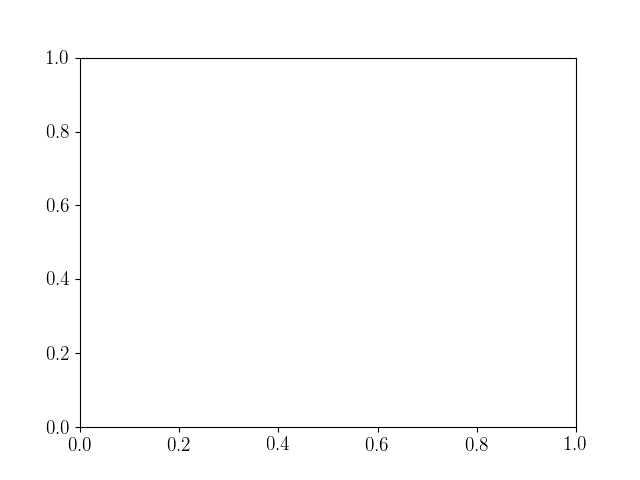

In [38]:
fig = plt.figure()
ax = fig.add_subplot(111)
fit_dict["final_spl"]
# ax.plot(S.wavelength, fit_dict["final_spl"](S.wavelength))
# ax.plot(fit_dict["SpectrumObject"].wavelength, S.flux/fit_dict["SpectrumObject"].flux)
# ax.plot(S.wavelength, S.flux)
# ax.plot(S.wavelength, S.flux*fit_dict["final_spl"](S.wavelength)*)


In [39]:
fit_dict["SpectrumObject"].scale_factor

221301253618343.59

In [40]:
fit_dict["SpectrumObject"].norm_factor

203.85919

<IPython.core.display.Javascript object>


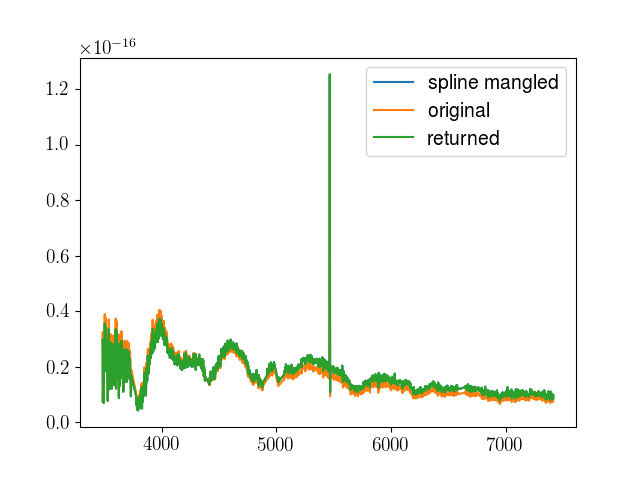

In [41]:
fig = plt.figure()
ax = fig.add_subplot(111)
fit_dict["final_spl"]
# ax.plot(S.wavelength, fit_dict["final_spl"](S.wavelength))
# ax.plot(fit_dict["SpectrumObject"].wavelength, S.flux/fit_dict["SpectrumObject"].flux)
# ax.plot(S.wavelength, S.flux)
ax.plot(S.wavelength, S.flux*fit_dict["final_spl"](S.wavelength), label="spline mangled")
ax.plot(S.wavelength, S.flux, label="original")
ax.plot(fit_dict["SpectrumObject"].wavelength, fit_dict["SpectrumObject"].flux/fit_dict["SpectrumObject"].norm_factor, 
        label="returned")

ax.legend()

In [42]:
data_table

filter,fitflux,spec_filterflux,mangledspec_filterflux,filter_object,mask,knot_colours,lambda_eff,weights
bytes12,float32,float32,float32,object,bool,str7,float64,float64
lower_anchor,0.600051,0.600051,0.804961,nan,False,#303535,3703.17996744,1.34148768964
BessellB,1.0,1.0,0.996993,<pycoco.classes.FilterClass object at 0x1172db550>,True,#0000ff,4354.41054934,1.09606985297
BessellV,1.66479,2.41388,1.66065,<pycoco.classes.FilterClass object at 0x1172e1b38>,True,#2ca02c,5436.8698117,0.688142434067
BessellR,1.36161,2.10636,1.3631,<pycoco.classes.FilterClass object at 0x1171ae630>,True,#c0392b,6416.11806798,0.632123429695
BessellI,0.876533,1.18455,0.878374,<pycoco.classes.FilterClass object at 0x1174292e8>,True,#8e44ad,8011.65864198,0.74371778116
upper_anchor,0.615137,0.615137,0.494479,nan,False,#303535,8871.44831678,0.803852680069
